# Freeze Bert Model Using CLS Token
### **Genre Label: 14**
### **Data: Balance || clean_df**
### **Bert Model: Uncase**
### **Total Sample Size: 2072 except for alternative (1154)**

In [1]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 32.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from transformers import BertTokenizer, TFBertModel
import torch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cleaned_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/cleaned_df.pkl')

In [5]:
train_df, remaining_df = train_test_split(cleaned_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.50, random_state=42)

print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)

Training set shape: (52240, 8)
Validation set shape: (6530, 8)
Test set shape: (6530, 8)


In [6]:
# look at the genre count for each label in training set
genre_counts = train_df['broad_genre'].value_counts()
genre_counts

,count
broad_genre,
Rock,10749
Pop,10560
Rhythm & Blues,4917
Country,4915
Jazz,3426
Electronic,3269
Metal,3180
Punk,3145
Folk,2559


In [9]:
# random undersample to fit the lowest class which is alternative
from sklearn.utils import resample

min_samples = 2072
undersampled_train_df = pd.DataFrame()

for genre in train_df['broad_genre'].unique():
    genre_df = train_df[train_df['broad_genre'] == genre]
    if len(genre_df) > min_samples:
        genre_df = resample(genre_df, replace=False, n_samples=min_samples, random_state=42)
    undersampled_train_df = pd.concat([undersampled_train_df, genre_df])

print('Training set genre distribution:')
print(undersampled_train_df['broad_genre'].value_counts())

Training set genre distribution:
broad_genre
Country           2072
Reggae            2072
Rock              2072
Punk              2072
Rhythm & Blues    2072
Hip Hop & Rap     2072
Metal             2072
Jazz              2072
Folk              2072
Pop               2072
Electronic        2072
Alternative       1154
Name: count, dtype: int64


In [10]:
# looking at genre count for validationa nd training set
print('Validation set genre distribution:')
print(val_df['broad_genre'].value_counts())

print('Test set genre distribution:')
print(test_df['broad_genre'].value_counts())

Validation set genre distribution:
broad_genre
Pop               1328
Rock              1324
Rhythm & Blues     631
Country            594
Punk               405
Metal              402
Jazz               398
Electronic         384
Folk               340
Hip Hop & Rap      284
Reggae             284
Alternative        156
Name: count, dtype: int64
Test set genre distribution:
broad_genre
Pop               1393
Rock              1326
Rhythm & Blues     607
Country            604
Electronic         426
Metal              416
Jazz               410
Punk               368
Folk               324
Hip Hop & Rap      284
Reggae             228
Alternative        144
Name: count, dtype: int64


In [11]:
train_text = undersampled_train_df['lyrics'].tolist()
val_text = val_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

train_label = undersampled_train_df['broad_genre'].tolist()
val_label = val_df['broad_genre'].tolist()
test_label = test_df['broad_genre'].tolist()

In [12]:
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
val_text = [preprocess_text(text) for text in val_text]
test_text = [preprocess_text(text) for text in test_text]

In [13]:
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
val_label = encode_label.transform(val_label)
test_label = encode_label.transform(test_label)

In [14]:
from transformers import BertTokenizer, TFBertModel
import torch


bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_SEQUENCE_LENGTH = 250

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [15]:
train_tokenized = bert_tokenizer(train_text,
                                 max_length=MAX_SEQUENCE_LENGTH,
                                 truncation=True,
                                 padding='max_length',
                                 return_tensors='tf')
train_inputs = [train_tokenized.input_ids, train_tokenized.token_type_ids, train_tokenized.attention_mask]
train_labels = np.array(train_label)

val_tokenized = bert_tokenizer(val_text,
                               max_length=MAX_SEQUENCE_LENGTH,
                               truncation=True,
                               padding='max_length',
                               return_tensors='tf')
val_inputs = [val_tokenized.input_ids, val_tokenized.token_type_ids, val_tokenized.attention_mask]
val_labels = np.array(val_label)

test_tokenized = bert_tokenizer(test_text,
                                max_length=MAX_SEQUENCE_LENGTH,
                                truncation=True,
                                padding='max_length',
                                return_tensors='tf')
test_inputs = [test_tokenized.input_ids, test_tokenized.token_type_ids, test_tokenized.attention_mask]
test_labels = np.array(test_label)



print('Train input IDs shape:', train_inputs[0].shape)
print('Validation input IDs shape:', val_inputs[0].shape)
print('Test input IDs shape:', test_inputs[0].shape)
print('First tokenized train input:', train_inputs[0][0])
print('First tokenized validation input:', val_inputs[0][0])
print('First tokenized test input:', test_inputs[0][0])

Train input IDs shape: (23946, 250)
Validation input IDs shape: (6530, 250)
Test input IDs shape: (6530, 250)
First tokenized train input: tf.Tensor(
[  101  2444  5091  2444  4553  7132  4553  7823  2477  6229  7348  2814
  7348  2393  2204  2814  2005  3736  3489  8307  3233  2175  7348  2814
  4982 11666  3422  2814  9811  2086  2175  2540  9436  2846  7348  2814
  7348  2393  2204  2814  2005  3736  3489  8307  3233  2175  7348  2814
  3398  2175  7348  2814   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

In [16]:
def freeze_bert_model_with_CLS(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=2e-5,
                          last_layer_num=11,
                          num_classes=14
                       ):
    # freezing all bert layers except the last transformer block
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model

In [17]:
num_classes = 14
checkpoint_dir = '/content/drive/MyDrive/w266/266 Final Project/model_checkpoints/'
bert_last_layer_num = 11

In [18]:
bert_model_5 = freeze_bert_model_with_CLS(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=100,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num,
    num_classes = num_classes
)

bert_model_5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                      

In [19]:
checkpoint_dir = '/content/drive/MyDrive/w266/266 Final Project/model_checkpoints/'

#calculate sample weights
sample_weight = np.ones(shape=(len(train_labels),))
for label in range(np.max(train_labels) + 1):
    class_weight = 1 - np.sum(train_labels == label) / len(train_labels)
    sample_weight[train_labels == label] = class_weight

# setting up check points
checkpoint_prefix = checkpoint_dir + 'bert_weights_%s'
checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)


In [20]:
bert_model_5_history = bert_model_5.fit(
    train_inputs,
    train_labels,
    #sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=3,
    batch_size=8,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/3


2994/2994 [==============================] - 719s 236ms/step - loss: 1.9314 - accuracy: 0.3235 - val_loss: 1.8272 - val_accuracy: 0.3228
Epoch 2/3
2994/2994 [==============================] - 698s 233ms/step - loss: 1.7244 - accuracy: 0.3877 - val_loss: 1.7699 - val_accuracy: 0.3590
Epoch 3/3
2994/2994 [==============================] - 694s 232ms/step - loss: 1.6465 - accuracy: 0.4171 - val_loss: 1.7794 - val_accuracy: 0.3447


749/749 [==============================] - 410s 543ms/step
Training Classification Report:
                precision    recall  f1-score   support

   Alternative       0.32      0.10      0.15      1154
       Country       0.48      0.68      0.56      2072
    Electronic       0.38      0.43      0.41      2072
          Folk       0.44      0.55      0.49      2072
 Hip Hop & Rap       0.84      0.78      0.81      2072
          Jazz       0.47      0.36      0.41      2072
         Metal       0.72      0.66      0.69      2072
           Pop       0.41      0.15      0.22      2072
          Punk       0.34      0.65      0.45      2072
        Reggae       0.50      0.67      0.57      2072
Rhythm & Blues       0.39      0.30      0.34      2072
          Rock       0.31      0.19      0.24      2072

      accuracy                           0.47     23946
     macro avg       0.47      0.46      0.44     23946
  weighted avg       0.47      0.47      0.45     23946



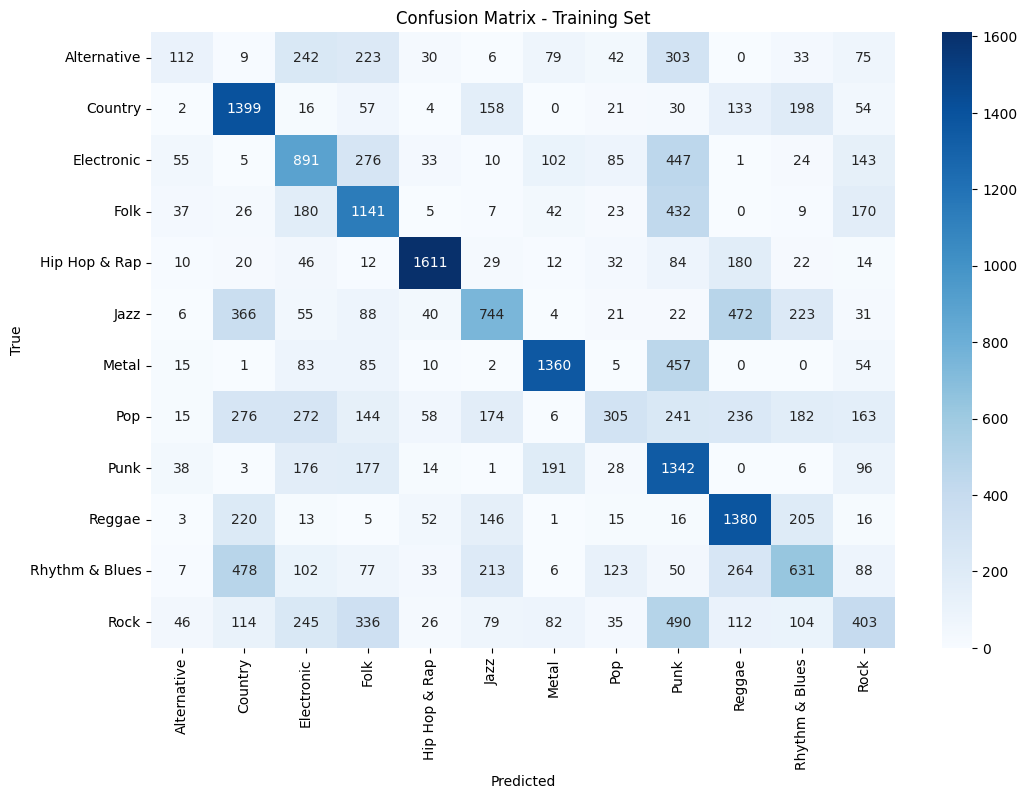

In [21]:
#classification report and confusion matrix for training:
train_predictions = bert_model_5.predict(train_inputs)
train_predictions = np.argmax(train_predictions, axis=1)
print('Training Classification Report:')
print(classification_report(train_labels, train_predictions, target_names=encode_label.classes_))

train_conf_matrix = confusion_matrix(train_labels, train_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Training Set')
plt.show()

In [26]:
#classification report and confusion matrix for validation set

val_predictions = bert_model_5.predict(val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(val_labels, val_predictions, target_names=encode_label.classes_))

205/205 [==============================] - 112s 544ms/step
                precision    recall  f1-score   support

   Alternative       0.09      0.04      0.05       156
       Country       0.39      0.59      0.47       594
    Electronic       0.24      0.41      0.30       384
          Folk       0.25      0.53      0.34       340
 Hip Hop & Rap       0.67      0.76      0.71       284
          Jazz       0.29      0.30      0.30       398
         Metal       0.63      0.63      0.63       402
           Pop       0.59      0.11      0.19      1328
          Punk       0.23      0.60      0.33       405
        Reggae       0.26      0.65      0.37       284
Rhythm & Blues       0.31      0.28      0.30       631
          Rock       0.44      0.16      0.23      1324

      accuracy                           0.34      6530
     macro avg       0.37      0.42      0.35      6530
  weighted avg       0.41      0.34      0.32      6530



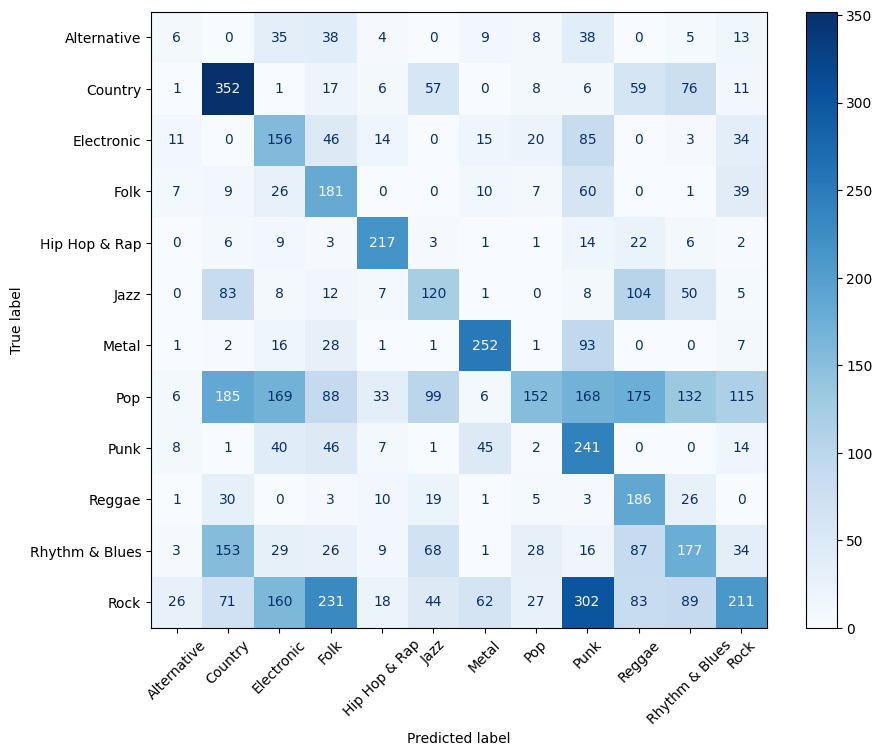

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()

# Hypertuning Bert Model
- 2 hidden layers
- hidden size = 768
- attention heads = 16

In [34]:
from transformers import BertConfig, TFBertModel
# defning custotm configuration for bert model to have attention head, intermediate/feed forward layer, dropout probability and attention drop out probability
def get_custom_bert_config(num_attention_heads=16):
    return BertConfig(
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=num_attention_heads,
        intermediate_size=3072,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
    )

In [38]:
custom_config = get_custom_bert_config(num_attention_heads=16)
bert_base_model = TFBertModel.from_pretrained('bert-base-uncased', config=custom_config)


def freeze_bert_model_update(bert_base_model,
                             max_sequence_length=128,
                             hidden_size=150,
                             dropout=0.3,
                             learning_rate=2e-5,
                             last_layer_num=11,
                             num_classes=14):
    # freezing all BERT layers except the last transformer block
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
bert_model_5_update = freeze_bert_model_update(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=150,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num,
    num_classes = num_classes
)

bert_model_5_update.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                    

In [40]:
bert_model_5_update_history = bert_model_5_update.fit(
    train_inputs,
    train_labels,
    #sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=3,
    batch_size=8,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/3


2994/2994 [==============================] - 741s 236ms/step - loss: 1.7861 - accuracy: 0.3770 - val_loss: 1.8160 - val_accuracy: 0.3357
Epoch 2/3
2994/2994 [==============================] - 697s 233ms/step - loss: 1.6357 - accuracy: 0.4259 - val_loss: 1.8129 - val_accuracy: 0.3412
Epoch 3/3
2994/2994 [==============================] - 693s 232ms/step - loss: 1.5678 - accuracy: 0.4451 - val_loss: 1.7308 - val_accuracy: 0.3674


In [41]:
val_predictions = bert_model_5_update.predict(val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(val_labels, val_predictions, target_names=encode_label.classes_))

205/205 [==============================] - 115s 543ms/step
                precision    recall  f1-score   support

   Alternative       0.08      0.01      0.02       156
       Country       0.40      0.59      0.48       594
    Electronic       0.23      0.43      0.30       384
          Folk       0.28      0.51      0.36       340
 Hip Hop & Rap       0.55      0.83      0.66       284
          Jazz       0.26      0.41      0.32       398
         Metal       0.47      0.82      0.59       402
           Pop       0.53      0.16      0.25      1328
          Punk       0.32      0.35      0.34       405
        Reggae       0.35      0.54      0.42       284
Rhythm & Blues       0.30      0.32      0.31       631
          Rock       0.44      0.21      0.28      1324

      accuracy                           0.37      6530
     macro avg       0.35      0.43      0.36      6530
  weighted avg       0.40      0.37      0.34      6530



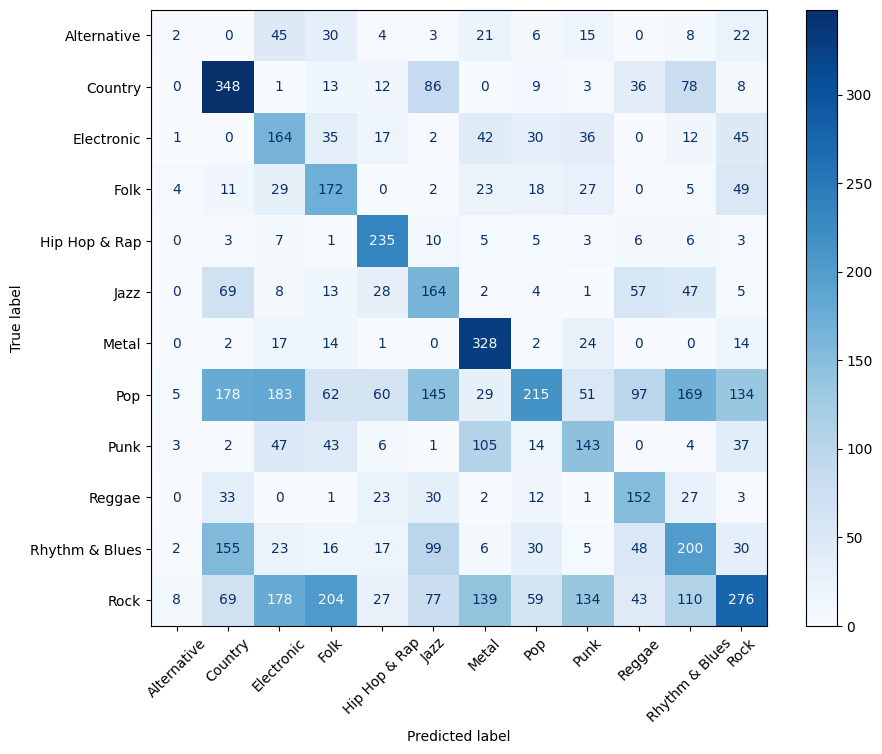

In [42]:
conf_matrix = confusion_matrix(val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()